In [2]:
# @title: imports, and graphics setup
import os
import warnings
import re
import sys
sys.path.append('..')

import numpy as np
import scipy.stats as stats
from scipy import integrate as integrate
from scipy.optimize import fsolve
from scipy.optimize import curve_fit
from scipy.constants import Boltzmann as kb

from tqdm.auto import tqdm, trange
from multiprocessing import Pool, TimeoutError
from joblib import Parallel, delayed

from Modules.pdfs import *
from Modules.potentials import harmonic_potential

import matplotlib
import matplotlib.pyplot as plt
import matplotlib_inline
import matplotlib.colors as mcol
import matplotlib.cm as cm
import matplotlib.patheffects as pe
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline
matplotlib.style.use('default')
matplotlib_inline.backend_inline.set_matplotlib_formats('png')

#### units converter

In [2]:
real_k_conv_factor = 1e-6

dt = 0.1
def convert_arbitrary_time_to_seconds(sim_gamma, real_k_conv_factor=1e-6, real_R=0.5*1e-6):
    water_viscosity = 0.00089
    real_gamma = 6 * np.pi * water_viscosity * real_R
    real_time_scale = real_gamma/real_k_conv_factor
    sim_time_scale = sim_gamma/1
    real_time =  real_time_scale/sim_time_scale #units: sec/sim_time
    return real_time #units: sec/sim_time

print('Real dt =',dt*convert_arbitrary_time_to_seconds(500, real_k_conv_factor=1*1e-6, real_R=0.5*1e-6), 'seconds')


print('Real k =',5*real_k_conv_factor, 'pN/um')

Real dt = 1.6776104770169494e-06 seconds
Real k = 4.9999999999999996e-06 pN/um


## Determine relaxation time (FIG 1)


In [54]:
dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 150000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

real_time = convert_arbitrary_time_to_seconds(gamma)
real_time_ms = real_time * 1e3  # convert to ms

### Harmonic Potential Parameters ###
k_harm = 2
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
omega_zero = k_harm/gamma

### resetting parameters ### 
delta_fractions = (k_harm/5)*np.linspace(0, 0.01, 6)
resetting_rates = delta_fractions/dt

sherf_nums = gamma*resetting_rates/k_harm
print('Sherf numbers:', sherf_nums)

resetting_rates_str = [f'{rate:.3f}'[1:] for rate in resetting_rates]
resetting_rates_str = ','.join(resetting_rates_str)
folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str}_K-{k_harm}'
print('Folder -', folder)

Sherf numbers: [ 0.  2.  4.  6.  8. 10.]
Folder - HarmonicPotentialTrajectories/R-.000,.008,.016,.024,.032,.040_K-2


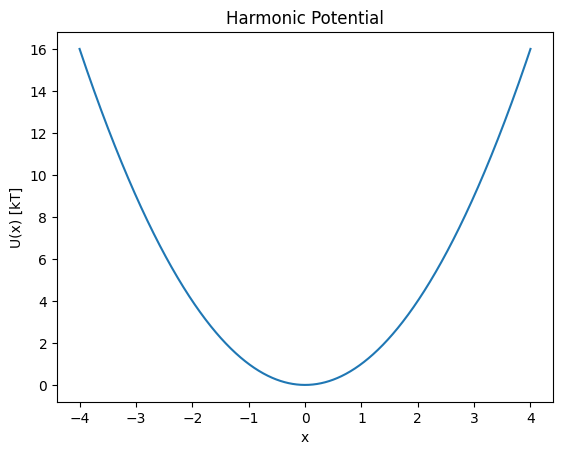

In [55]:
### plot potential ###
from Modules.potentials import harmonic_potential
potential_x = np.linspace(-4, 4, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y)
plt.xlabel('x')
plt.ylabel('U(x) [kT]')
plt.title('Harmonic Potential')
plt.show()

In [56]:
histograms_per_rate = np.load(folder+'/histograms_per_rate.npy')

In [57]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates),vmax=max(resetting_rates))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

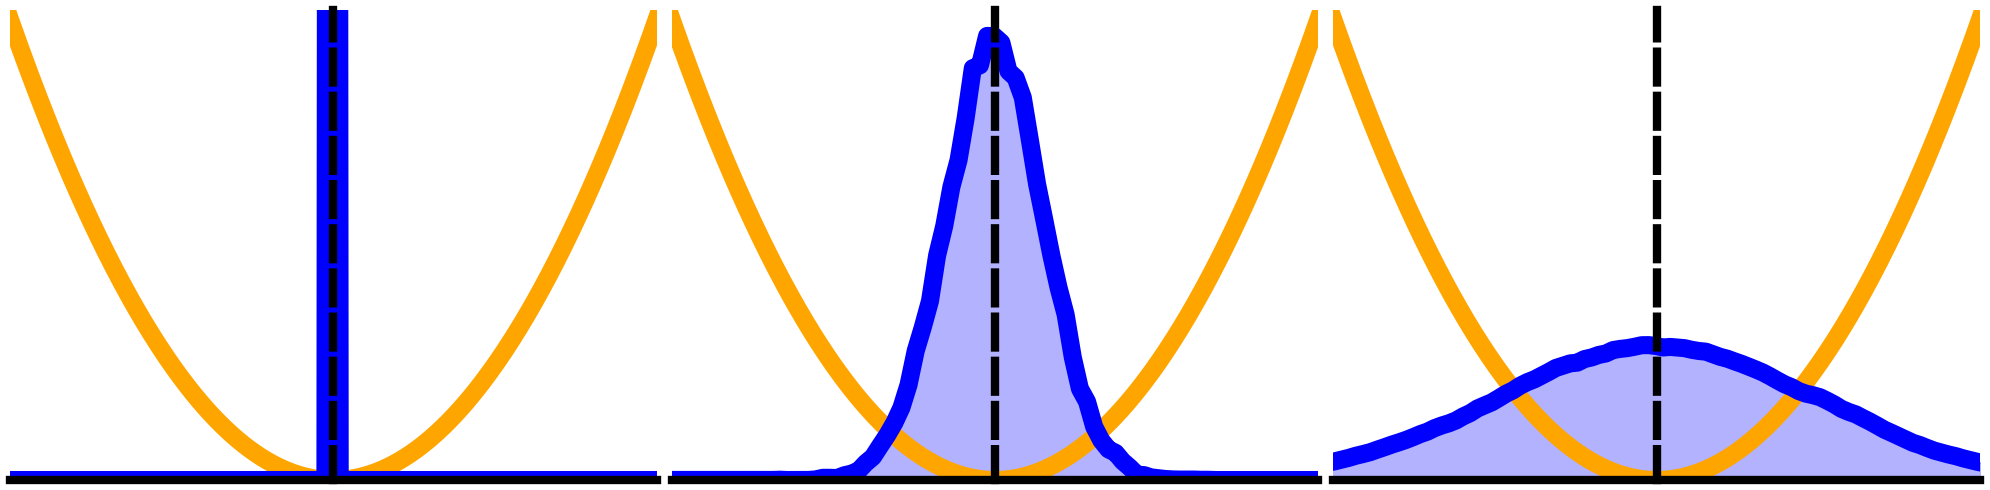

In [71]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()
color = cpick.to_rgba(0.0)  # No resetting rate corresponds to 0.0
boltzmann_histograms = histograms_per_rate[0]
xlim = (-1.4, 1.4)
ylim = (0, 2)
for i in range(3):
    if i == 0:
        hist, bin_centers = boltzmann_histograms[0]
    elif i == 1:
        hist, bin_centers = boltzmann_histograms[24]
    else:
        hist, bin_centers = boltzmann_histograms[-1]
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', 0), lw=6,linestyle='--')
    axs[i].spines['bottom'].set(lw=6)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=13, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=13, zorder=1)
    axs[i].set_xlim(*xlim)
    axs[i].set_ylim(*ylim)
plt.tight_layout()
figname = 'a - Boltzmann PDF Relaxation - Harmonic.svg'
path = os.path.join('Figures/Figure1',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

resetting used:  6.0 $\omega_0$
resetting used:  1.4306062300395088 $ms$


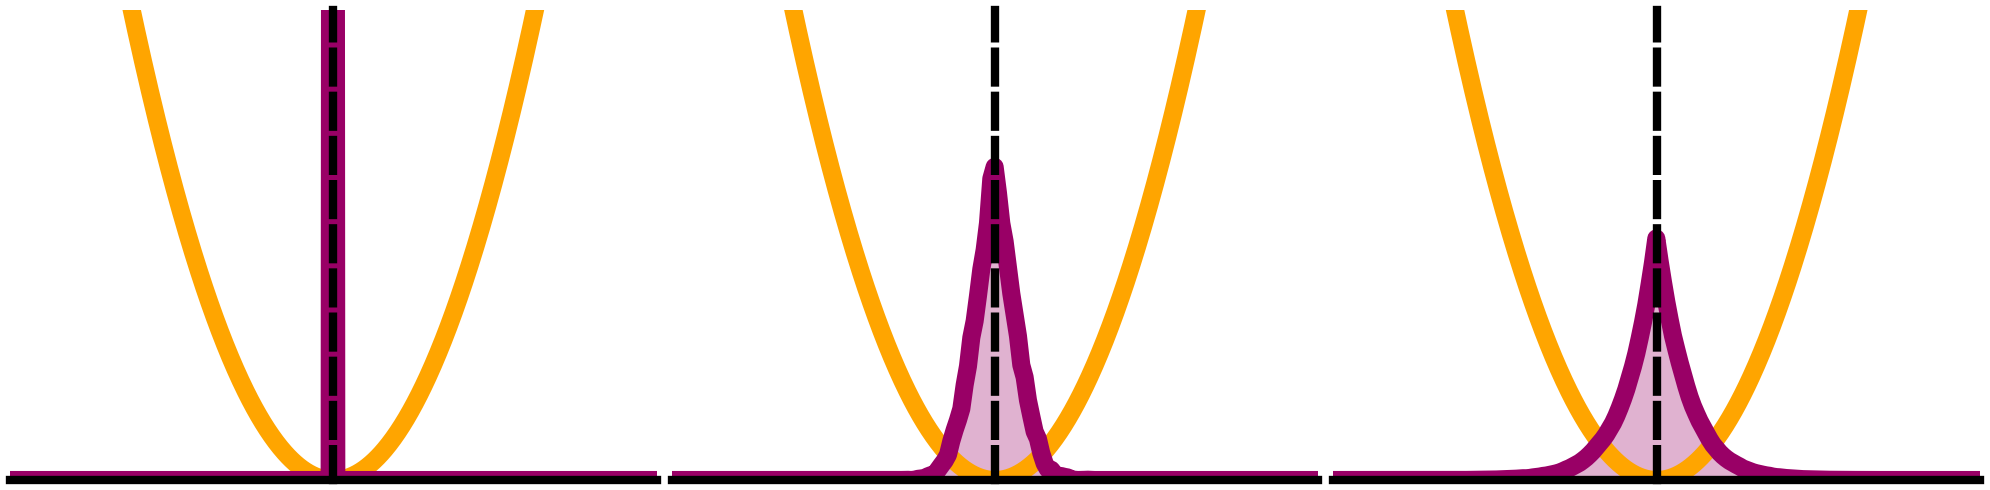

In [73]:
### plot no resetting histograms ###



fig, ax = plt.subplots(1, 3, figsize=(20, 5))
axs = ax.ravel()

r_indx = 3
resetting_histograms = histograms_per_rate[r_indx]
print('resetting used: ', resetting_rates[r_indx]/omega_zero, '$\\omega_0$')
print('resetting used: ', resetting_rates[r_indx]/real_time_ms, '$ms$')
color= cpick.to_rgba(resetting_rates[r_indx]) 
xlim = (-3, 3)
ylim = (0, 3.5) 
for i in range(3):
    if i == 0:
        hist, bin_centers = resetting_histograms[0]
    elif i == 1:
        hist, bin_centers = resetting_histograms[24]
    else:
        hist, bin_centers = resetting_histograms[-1]
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)
    axs[i].spines['left'].set(position=('data', 0), lw=6,linestyle='--')
    axs[i].spines['bottom'].set(lw=6)
    axs[i].set_yticks([])
    axs[i].set_xticks([])
    axs[i].plot(bin_centers, hist,color=color, linewidth=13, zorder=2)
    axs[i].fill_between(bin_centers, hist, alpha=0.3, color=color)
    axs[i].plot(potential_x, potential_y, label='U(x)', color='Orange', linewidth=13, zorder=1)
    axs[i].set_xlim(*xlim)
    axs[i].set_ylim(*ylim)
plt.tight_layout()
figname = 'a - Resetting PDF Relaxation - Harmonic - with stronger resetting.svg'
path = os.path.join('Figures/Figure1',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

In [61]:
KLDs_per_rate =  np.load(folder+'/KLD_per_rate.npy')

In [62]:
samples = 5
target_distribution_samples = 500
steady_state = 12000
timesteps = np.arange(0, steady_state, 5)

In [63]:
kld_thresholds = []
for kld_per_time in KLDs_per_rate:
    kld_threshold = np.min(kld_per_time[-50:])
    kld_threshold_std = np.std(kld_per_time[-50:])
    kld_threshold = kld_threshold + 10*kld_threshold_std
    kld_thresholds.append(kld_threshold)
kld_threshold = max(kld_thresholds)
print('KLD threshold:', kld_threshold)

platue_index_per_r = []
for kld_per_time, r in zip(KLDs_per_rate, resetting_rates):
    platue_index = np.where(kld_per_time < kld_threshold)[0][0]
    timestep_platue = timesteps[platue_index]*dt
    platue_index_per_r.append(timestep_platue)
platue_index_per_r = np.array(platue_index_per_r)

KLD threshold: 0.03714447803436968


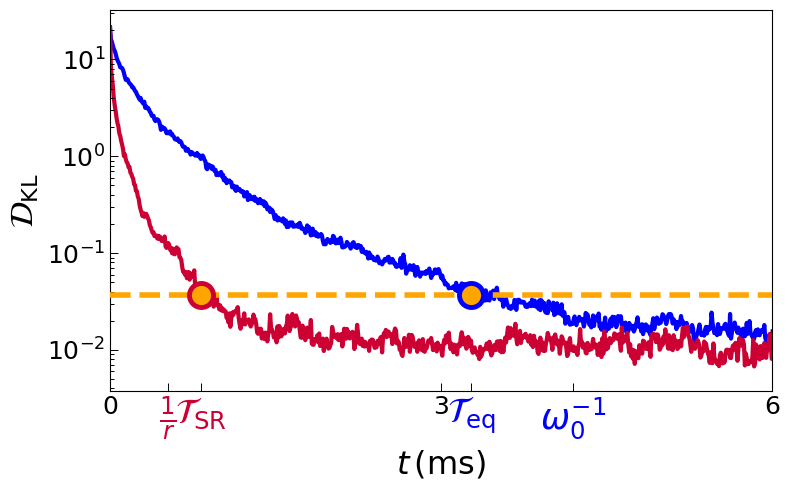

In [ ]:

fig, ax = plt.subplots(figsize=(8, 5))

resetting_to_print = [resetting_rates[0], resetting_rates[4]]
x_ticks = []
for kld_per_time, platue, r in zip(KLDs_per_rate, platue_index_per_r, resetting_rates):
    if r not in resetting_to_print:
        continue
    adjusted_timesteps = timesteps*dt*real_time_ms
    adjusted_platue = platue*real_time_ms
    x_ticks.append(adjusted_platue)
    im=ax.semilogy(adjusted_timesteps,kld_per_time, label=f'{r:.3f}', color=cpick.to_rgba(r), lw=3, zorder=1)
    #if r != 0:
        #im=ax.axvline(x=real_time_ms/resetting_to_print[1], color=cpick.to_rgba(r), linestyle='--', label='$\\r^{-1}$', lw=4, zorder=5)
    im=ax.scatter(adjusted_platue, kld_threshold, color='orange', marker='o', s=300, edgecolor=cpick.to_rgba(r), linewidth=3.5, zorder=10)
#im=ax.axvline(x=typical_relaxation_time*real_time_ms, color='blue', linestyle='--', label='$\\omega_0^{-1}$', lw=4, zorder=5)
im = ax.axhline(kld_threshold, color='orange', linestyle='--', label='KLD threshold', lw=4, zorder=5)
threshold_handle = plt.Line2D([0],[0],linestyle='--',color='orange', label=f'threshold')
intersect_handle = plt.Line2D([0],[0],linestyle='', marker='o',color='Orange', label=f'$\\tau$', markersize=8)
resetting_rate_handles = []
for r in resetting_rates:
    if r not in resetting_to_print:
        continue
    h = plt.Line2D([0],[0],color=cpick.to_rgba(r),label=f'r={r:.3f}', linestyle='-', lw=3)
    resetting_rate_handles.append(h)
handles = resetting_rate_handles
ax.set_xlabel('$t \\,(\\mathrm{ms})$', fontsize=23)
ax.set_ylabel('$\\mathcal{D}_{\\rm KL}$',fontsize=23)
ax.set_xlim(0, 6)
ax.set_yscale('log')

relax_time_values = [typical_relaxation_time*real_time_ms, real_time_ms/resetting_to_print[1]]
relax_time_labels = ['$\\omega_0^{-1}$', '$\\frac{1}{r}$']
x_ticks_values = np.concatenate(([0,3,6], x_ticks, relax_time_values))
x_ticks_labels = [0,3,6,"$\\mathcal{T}_{\\rm eq}$","$\\mathcal{T}_{\\rm SR}$"] + relax_time_labels
ax.set_xticks(x_ticks_values, x_ticks_labels)
xtick_labels = ax.get_xticklabels()
ax.tick_params(axis='both', which='major', labelsize=18, direction='in',length=6, width=0.7)
ax.tick_params(axis='both', which='minor', labelsize=18, direction='in',length=3, width=0.7)
x_ticks_colors = ['black']*3 + ['blue', cpick.to_rgba(resetting_to_print[1])] + ['blue', cpick.to_rgba(resetting_to_print[1])]

for i, (c, label) in enumerate(zip(x_ticks_colors, xtick_labels)):
    label.set_color(c)
    if c != 'black':
        label.set_fontsize(25)
        if i > 5:
            #label.set_y(-0.02)
            label.set_fontsize(25)
            #label.set_color('darkred')
#ax.set_xticklabels(x_ticks_labels, **x_ticks_params)
#ax.set_xticks(x_ticks, [f'{x:.2f}' for x in x_ticks])
#ax.legend(handles=handles, fontsize=18, loc='upper right', handlelength=0.75, handletextpad=0.5)
plt.tight_layout()
plt.savefig('Figures/determine relaxation time.svg', format='svg', dpi=500)
plt.show()


## Initial Conditions (Fig 4)

In [31]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 16000
batch_size = 8000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]

typical_relaxation_time = gamma/k_harm
print(typical_relaxation_time)

typical_length_scale = np.sqrt(D*typical_relaxation_time)
print(typical_length_scale)
### resetting parameters ### 
delta_fraction = 0.002
resetting_rate = delta_fraction/dt
start_positions = np.linspace(np.floor(-10*typical_length_scale), 0, 11)[::-1]
print(start_positions)

start_positions_str = [f'{abs(x):.2f}'[:] for x in start_positions]
start_positions_str = ','.join(start_positions_str)
folder = f'HarmonicPotentialTrajectories/x_0-{start_positions_str}'
print('Folder -', folder)

100.0
0.4472135954999579
[ 0.  -0.5 -1.  -1.5 -2.  -2.5 -3.  -3.5 -4.  -4.5 -5. ]
Folder - HarmonicPotentialTrajectories/x_0-0.00,0.50,1.00,1.50,2.00,2.50,3.00,3.50,4.00,4.50,5.00


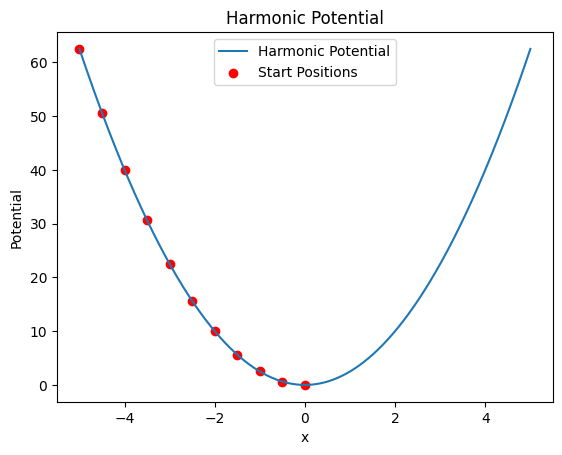

In [32]:
### plot potential ###
potential_x = np.linspace(-5, 5, 1000)
potential_y = harmonic_potential(potential_x, k_harm)/kT
plt.plot(potential_x, potential_y, label='Harmonic Potential')
plt.scatter(start_positions, harmonic_potential(np.array(start_positions), k_harm)/kT, color='red', label='Start Positions')
plt.title('Harmonic Potential')
plt.xlabel('x')
plt.ylabel('Potential')
plt.legend()
plt.show()

In [33]:
histograms_per_start_pos = np.load(folder+'/histograms_per_start_pos.npy')

start position: 0.0 $\sigma$
start position: -2.23606797749979 $\sigma$
start position: -4.47213595499958 $\sigma$


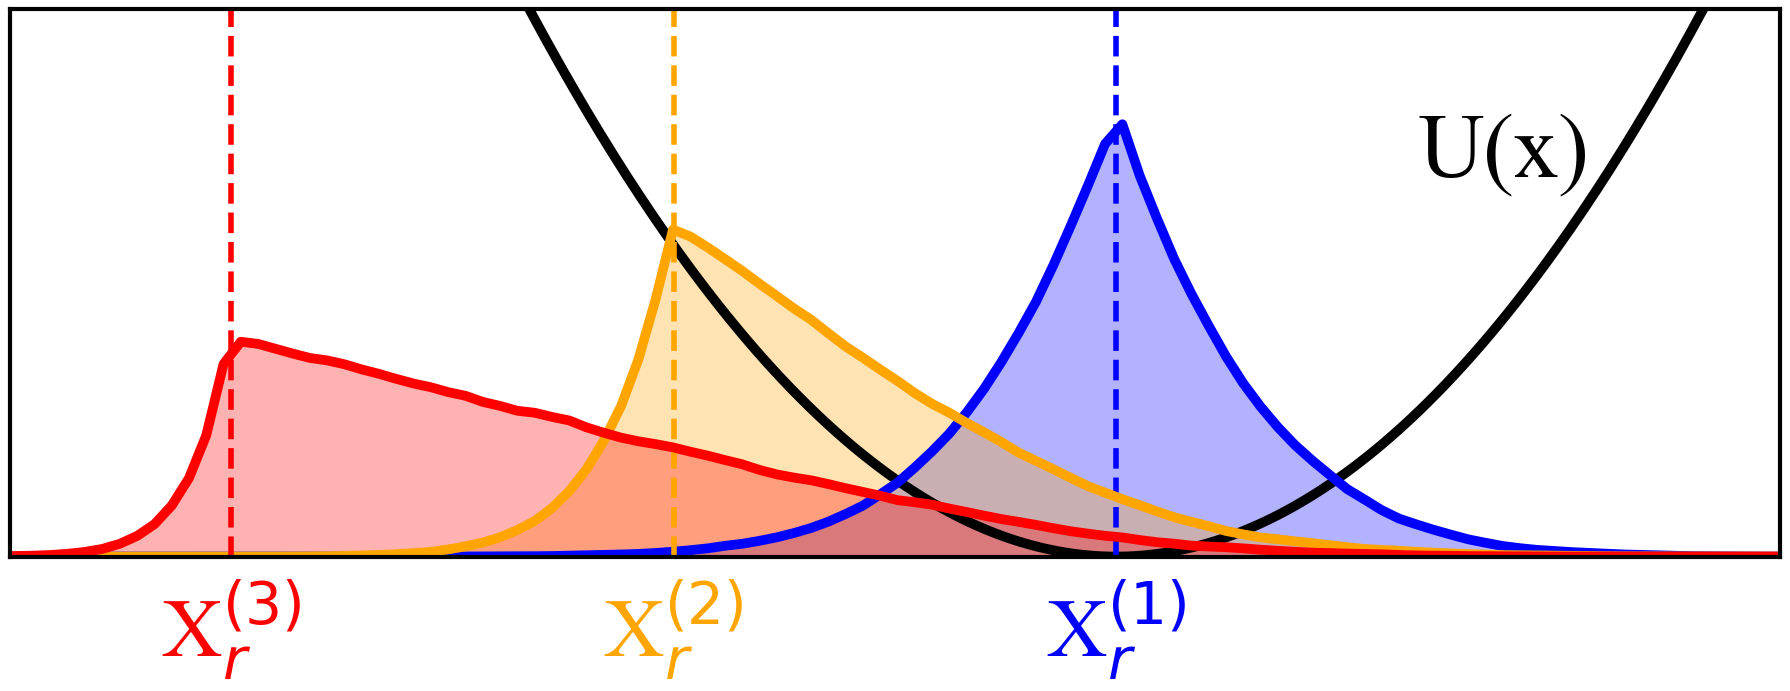

In [35]:
### plot no resetting histograms ###

fig, ax = plt.subplots(1, 1, figsize=(18, 7), edgecolor='black')
xlim = (-2.5, 1.5)
ylim = (0, 2.2)
positions_to_print = [0, 2, 4]
c = 0
for i ,hists in enumerate(histograms_per_start_pos):
    if i not in positions_to_print:
        continue
    if i == positions_to_print[-1]:
        color = 'red'
    elif i == positions_to_print[0]:
        color = 'blue'
    elif i == positions_to_print[1]:
        color = 'orange'
    c+= 1
    print('start position:', start_positions[i]/typical_length_scale, '$\\sigma$')
    ss_hist, ss_bin_centers = hists[-1]
    ax.spines['top'].set_visible(True)
    ax.spines['top'].set(lw=3)
    ax.spines['right'].set_visible(True)
    ax.spines['right'].set(lw=3)
    ax.spines['left'].set_visible(True)
    ax.spines['left'].set(lw=3)
    ax.spines['bottom'].set(lw=3)
    ax.set_yticks([])
    ax.set_xticks([])
    ax.text(
    start_positions[i], -0.5,
    r"X$_r^{("+str(c)+")}$",
    fontsize=60, ha='center', va='bottom', color=color,
    fontdict={'family': 'Times New Roman'}
) 
    ax.axvline(start_positions[i], color=color, linestyle='--', lw=4)
    ax.plot(ss_bin_centers, ss_hist,color=color, linewidth=7, zorder=2)
    ax.fill_between(ss_bin_centers, ss_hist, alpha=0.3, color=color)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
ax.plot(potential_x, potential_y*0.5, label='U(x)', color='Black', linewidth=7, zorder=1)
ax.text(0.875, 1.45, 'U(x)', fontsize=65, ha='center', va='bottom', color='Black', font={'family': 'Times New Roman'})
start_positions_handle = [plt.Line2D([0], [0], color='black', linewidth=4, linestyle='--', label='Resetting Position')]
potential_handle = [plt.Line2D([0], [0], color='Orange', linewidth=7, label='U(x)')]
plt.tight_layout()
figname = 'Fig 3 - NESS by Xr.svg'
path = os.path.join('Figures/Figure3',figname)
plt.savefig(path,bbox_inches='tight',format='svg', dpi=500)
plt.show()

## Initial Conditions (Fig 5)

### Varying $X_r$ and S number - Updated

In [22]:
### Simulation Parameters ###

dt = 0.1
gamma = 500
kT = 1
steps = 10000
n_particles = 20000
batch_size = 10000
batches = int(n_particles/batch_size)
D=kT/gamma

### Harmonic Potential Parameters ###
k_harm = 5
force_args = [k_harm]
typical_relaxation_time = gamma/k_harm
typical_length_scale = np.sqrt(kT/k_harm)

### relaxation vs S-number ###
start_position_ratios_relaxation_vs_Snum = np.array([0, 0.1, 0.3, 1, 3])
start_positions_relaxation_vs_Snum = -start_position_ratios_relaxation_vs_Snum * typical_length_scale
start_positions_relaxation_vs_Snum_str = [f'{pos:.3f}'[1:] for pos in start_positions_relaxation_vs_Snum]
start_positions_relaxation_vs_Snum_str = ','.join(start_positions_relaxation_vs_Snum_str)

### resetting parameters ### 
### relaxation vs S-number ###

#linear-spaced
S_ratios = np.concatenate((np.linspace(0, 2, 5), np.linspace(2, 5, 4)[1:]))
delta_fractions_relaxation_vs_Snum = (k_harm*S_ratios/gamma)*dt

colors_relaxation_vs_Snum = cm.rainbow(np.linspace(0, 1, len(start_positions_relaxation_vs_Snum)))
resetting_rates_relaxation_vs_Snum = delta_fractions_relaxation_vs_Snum/dt
resetting_rates_relaxation_vs_Snum_str = [f'{rate:.2f}'[1:] for rate in resetting_rates_relaxation_vs_Snum]
resetting_rates_relaxation_vs_Snum_str = ','.join(resetting_rates_relaxation_vs_Snum_str)
sherf_nums_relaxation_vs_Snum = gamma*resetting_rates_relaxation_vs_Snum/k_harm
print('Sherf numbers relaxation vs S-number:', sherf_nums_relaxation_vs_Snum)


### folder names and subfolders ###

### relaxation vs S-number ###
folder_relaxation_vs_s_num = f'HarmonicPotentialTrajectories/R-{resetting_rates_relaxation_vs_Snum_str}_X-{start_positions_relaxation_vs_Snum_str}'
if k_harm != 5:
    folder_relaxation_vs_s_num += f'_k={k_harm}'
subfolders_relaxation_vs_s_num = [folder_relaxation_vs_s_num + f'/X-{start_position:.3f}' for start_position in start_positions_relaxation_vs_Snum]

print('Folder -', folder_relaxation_vs_s_num)
print('Subfolders -', subfolders_relaxation_vs_s_num)

Sherf numbers relaxation vs S-number: [0.  0.5 1.  1.5 2.  3.  4.  5. ]
Folder - HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342
Subfolders - ['HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.000', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.045', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.134', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.447', 'HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--1.342']


In [23]:
### Load Data ###

### relaxation vs S-number ###
platue_indices_per_r_per_start = np.load(folder_relaxation_vs_s_num+'/platue_indices_per_r_per_start.npy', allow_pickle=True)
mean_platue_indices_per_r_per_start = np.load(folder_relaxation_vs_s_num+'/mean_platue_indices_per_r_per_start.npy', allow_pickle=True)
std_platue_indices_per_r_per_start = np.load(folder_relaxation_vs_s_num+'/std_platue_indices_per_r_per_start.npy', allow_pickle=True)

In [24]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",['orange','r',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(abs(start_positions_relaxation_vs_Snum)),vmax=max(abs(start_positions_relaxation_vs_Snum)))
# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

#### Figure 

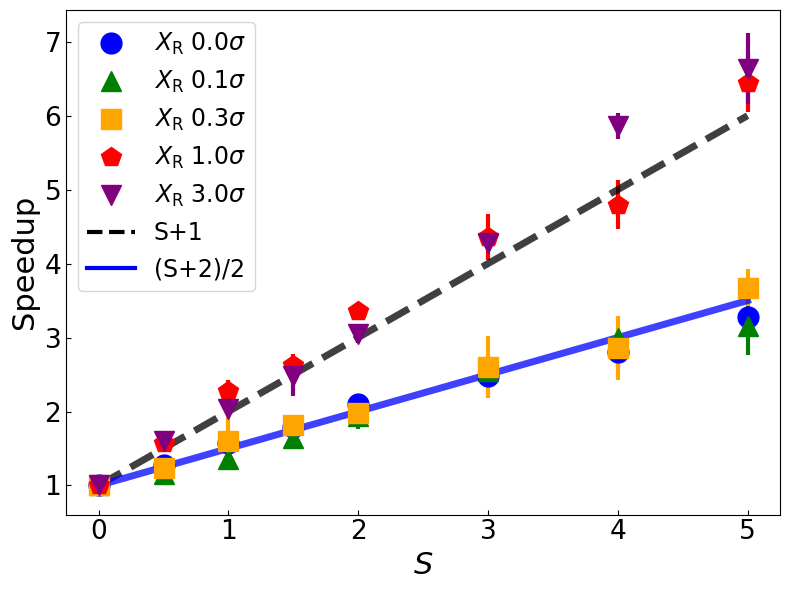

In [25]:
### plotting linear spaced data ###

slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p','v']
matplotlib_colors = ['blue', 'green', 'orange', 'red', 'purple']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (mean_platue_index_per_r,std_platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(mean_platue_indices_per_r_per_start, std_platue_indices_per_r_per_start, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    rel_error = std_platue_index_per_r/mean_platue_index_per_r
    y_values = mean_platue_index_per_r[0]/mean_platue_index_per_r
    ax.errorbar(sherf_nums_relaxation_vs_Snum, y_values, yerr=rel_error * y_values, linestyle='', marker=symbol, lw=3, ms=15, color=c)#, color=cpick.to_rgba(abs(start_position)))
    #plt.errorbar(sherf_num_patch[-1], final_platue/boltz_platue, linestyle='--', marker = 'o', lw=3, ms=10, color=c_start)
#plt.plot(resetting_rates, mean_platue_indices_per_r, linestyle='--', lw=3, color='black', alpha=0.3)
#plt.plot(sherf_nums_relaxation_vs_Snum[-9:], sherf_nums_relaxation_vs_Snum[-9:]**slope_1, linestyle='--', lw=3, color='black', alpha=0.3, label=f'Slope {slope_1}')
ax.plot(sherf_nums_relaxation_vs_Snum, 1/func1(sherf_nums_relaxation_vs_Snum), linestyle='--', lw=5, color='black', alpha=0.75, label='mean - 1/(1+x)')
ax.plot(sherf_nums_relaxation_vs_Snum, 1/func2(sherf_nums_relaxation_vs_Snum), linestyle='-', lw=5, color='blue', alpha=0.75, label='variance - 2/(2+x)')
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
theory_handles = [plt.Line2D([0], [0], color='black', lw=3, linestyle='--', label='S+1'),
                  plt.Line2D([0], [0], color='blue', lw=3, linestyle='-', label='(S+2)/2')]
handles = start_position_handles + theory_handles
ax.legend(handles=handles, loc='upper left', fontsize=17)
ax.set_xlabel('$S$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
#ax.set_xscale('log')
#ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
#ax.set_xticks([1, 3, 5], [1, 3, 5])
#ax.set_yticks([1, 2 ,6], [1,2,6])
fig.tight_layout()
fig_name = 'Fig 5 - Speedup by S - Vary Xr.svg'
saving_folder = 'Figures/Figure5'
path = os.path.join(saving_folder, fig_name)
plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

In [26]:
### load histograms per rate per X_R ###
SS_second_moment_boltz = kT/k_harm
SS_mean_per_rate_per_start = []
SS_second_moment_per_rate_per_start = []
SS_variance_per_rate_per_start = []
average_hists_per_rate_per_start = []
histograms_per_rate_per_start = np.load(folder_relaxation_vs_s_num+'/histograms_per_rate_per_start.npy', allow_pickle=True)
SS_samples = 50
for subfolder in subfolders_relaxation_vs_s_num:
    means_per_start = []
    second_moments_per_start = []
    variances_per_start = []
    histograms_per_rate = np.load(subfolder+'/histograms_per_rate.npy', allow_pickle=True)
    average_hists_per_start = []
    print(f'Histograms per rate per start shape for {subfolder}:', histograms_per_rate.shape)
    for i, histogram in enumerate(histograms_per_rate):
        average_hist = np.average(histogram[-SS_samples:], axis=0)
        total_samples = np.sum(average_hist[0])
        normalization_factor = np.trapezoid(average_hist[0], average_hist[1])
        if 1 - normalization_factor > 0.0001:
            print(f'Warning: Histogram for {subfolder} does not sum to 1, normalization factor: {normalization_factor}')
        mean = np.sum(average_hist[0]*average_hist[1]/(total_samples))
        second_moment = np.sum((average_hist[0]/total_samples)*(average_hist[1])**2)
        variance = np.sum((average_hist[0]/total_samples)*((average_hist[1]-mean)**2))
        means_per_start.append(mean)
        second_moments_per_start.append(second_moment)
        variances_per_start.append(variance)
        average_hists_per_start.append(average_hist)
    SS_mean_per_rate_per_start.append(means_per_start)
    SS_second_moment_per_rate_per_start.append(second_moments_per_start)
    SS_variance_per_rate_per_start.append(variances_per_start)
    average_hists_per_rate_per_start.append(average_hists_per_start)
SS_mean_per_rate_per_start = np.array(SS_mean_per_rate_per_start)
SS_second_moment_per_rate_per_start = np.array(SS_second_moment_per_rate_per_start)
SS_variance_per_rate_per_start = np.array(SS_variance_per_rate_per_start)
average_hists_per_rate_per_start = np.array(average_hists_per_rate_per_start)

Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.000: (8, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.045: (8, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.134: (8, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--0.447: (8, 1601, 2, 200)
Histograms per rate per start shape for HarmonicPotentialTrajectories/R-.00,.01,.01,.01,.02,.03,.04,.05_X-0.000,0.045,0.134,0.447,1.342/X--1.342: (8, 1601, 2, 200)


Mean platue index per r: [0.77   0.6025 0.49   0.43   0.3675 0.31   0.275  0.235 ]
Std platue index per r: [0.02   0.0225 0.005  0.     0.0075 0.015  0.02   0.005 ]
Mean platue index per r: [0.7575 0.6575 0.5575 0.4625 0.39   0.2975 0.2525 0.24  ]
Std platue index per r: [0.0125 0.0075 0.0175 0.0075 0.035  0.0025 0.0075 0.03  ]
Mean platue index per r: [0.8075 0.655  0.505  0.445  0.4075 0.31   0.2825 0.22  ]
Std platue index per r: [0.0675 0.06   0.105  0.035  0.0075 0.05   0.0425 0.015 ]
Mean platue index per r: [1.5475 0.98   0.68   0.5875 0.46   0.355  0.3225 0.24  ]
Std platue index per r: [0.0025 0.01   0.045  0.0325 0.     0.025  0.0225 0.015 ]
Mean platue index per r: [2.505  1.565  1.2275 1.0125 0.8225 0.585  0.4275 0.3775]
Std platue index per r: [0.075  0.005  0.0025 0.1075 0.0325 0.01   0.0125 0.0275]


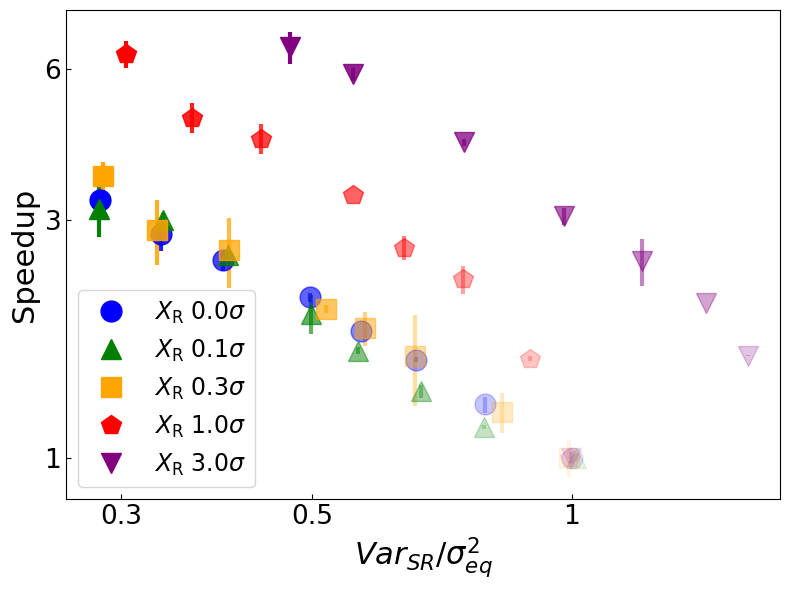

In [27]:

### plotting linear spaced data ###
slope_1 = -1

func1 = lambda x: 1/(1+x)
func2 = lambda x: 2/(2+x)
symbols = ['o', '^', 's', 'p', 'v']
matplotlib_colors = ['blue', 'green', 'orange', 'red', 'purple']

fig, ax = plt.subplots(figsize=(8, 6))

for i, (mean_platue_index_per_r, std_platue_index_per_r, c, start_position, boltz_platue, symbol) in enumerate(zip(mean_platue_indices_per_r_per_start, std_platue_indices_per_r_per_start, matplotlib_colors, start_positions_relaxation_vs_Snum, boltzmann_platue_index_per_start_T_vs_S, symbols)):
    alphas = np.linspace(0.1, 1, len(mean_platue_index_per_r))
    print('Mean platue index per r:', mean_platue_index_per_r)
    print('Std platue index per r:', std_platue_index_per_r)
    rel_error = std_platue_index_per_r/mean_platue_index_per_r
    y_values = mean_platue_index_per_r[0]/mean_platue_index_per_r
    y_err = rel_error * y_values
    #yerr = np.sqrt((std_platue_index_per_r/mean_platue_index_per_r[0])**2 + ((mean_platue_index_per_r*std_platue_index_per_r[0])/(mean_platue_index_per_r[0]**2))**2)
    [ax.errorbar(SS_variance_per_rate_per_start[i][j]/SS_second_moment_boltz, y_values[j], yerr=y_err[j], linestyle='', marker=symbol, lw=3, ms=15, color=c, alpha=alphas[j]) for j in range(len(alphas))]#, color=cpick.to_rgba(abs(start_position)))
    #ax.scatter(SS_variance_per_rate_per_start[i]/SS_second_moment_boltz, boltz_platue/mean_platue_index_per_r, linestyle='', marker=symbol, lw=3, s=150, color=c, alpha=alphas)#, color=cpick.to_rgba(abs(start_position)))
start_position_handles = [plt.Line2D([0], [0],linestyle='',color=c, marker=symbol,ms=15, label='$X_{\\rm R} $' + f' {abs(start_position)/typical_length_scale:.1f}$\\sigma$') for c, symbol, start_position in zip(matplotlib_colors, symbols, start_positions_relaxation_vs_Snum)]
handles = start_position_handles
ax.legend(handles=handles, loc='lower left', fontsize=17)
ax.set_xlabel('$Var_{SR}/\\sigma^2_{eq}$', fontsize=22)
ax.set_ylabel('Speedup', fontsize=22)
#ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=32)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=19, direction='in')
### Clear ticks ###
ax.set_xticks([], minor=True)
ax.set_yticks([], minor=True)
ax.set_xticklabels([], minor=True)
ax.set_yticklabels([], minor=True)
## set ticks ## 
ax.set_xticks([0.3, 0.5, 1], [0.3, 0.5, 1])
ax.set_yticks([1, 3 ,6], [1,3,6])
fig.tight_layout()
fig_name = 'Fig 6 - Speedup by Var - Vary Xr.svg'
saving_folder = 'Figures/Figure6_optional'
path = os.path.join(saving_folder, fig_name)
plt.savefig(path, bbox_inches='tight', format='svg', dpi=300)
plt.show()

## Sherf Number for X=0 (FIG 2)

In [81]:

dt = 0.1
gamma = 500
r_varing_k = 0.002/dt
k_varing_r = 5
kT = 1

varing_k_folder = 'HarmonicPotentialTrajectories/K-1,3,5,7,9,12,14,16,18,20'
varying_k_folder_boltz = 'HarmonicPotentialTrajectories/K_r_0-1,3,5,7,9,12,14,16,18,20'
varing_r_folder = 'HarmonicPotentialTrajectories/R-.000,.020,.040,.060,.080,.100'
Ks_varing_k = np.load(varing_k_folder+'/k_harms.npy')
Rs = np.load(varing_r_folder+'/resetting_rates.npy')
mean_relaxation_times_varing_k_raw = np.load(varing_k_folder+'/mean_platue_indices_per_K.npy')
mean_relaxation_times_varing_k_boltz = np.load(varying_k_folder_boltz+'/mean_platue_indices_per_K_boltz.npy')
mean_relaxation_times_varing_r = np.load(varing_r_folder+'/mean_platue_indices_per_r.npy')
std_relaxation_times_varing_k_raw = np.load(varing_k_folder+'/std_platue_indices_per_K.npy')
std_relaxation_times_varing_k_boltz = np.load(varying_k_folder_boltz+'/std_platue_indices_per_K_boltz.npy')
std_relaxation_times_varing_r = np.load(varing_r_folder+'/std_platue_indices_per_r.npy')
mean_relaxation_times_varing_k = mean_relaxation_times_varing_k_raw/mean_relaxation_times_varing_k_boltz
mean_relaxation_times_varing_r = mean_relaxation_times_varing_r/mean_relaxation_times_varing_r[0]
std_relaxation_times_varing_k = std_relaxation_times_varing_k_raw/mean_relaxation_times_varing_k_boltz
std_relaxation_times_varing_r = std_relaxation_times_varing_r/mean_relaxation_times_varing_r[0]


sherf_nums_varing_k = gamma * r_varing_k / Ks_varing_k
sherf_nums_varing_r = gamma * Rs / k_varing_r
print('sherf_nums_varing_r',sherf_nums_varing_r)
print('sherf_nums_varing_k',sherf_nums_varing_k)


sherf_nums_varing_r [ 0.  2.  4.  6.  8. 10.]
sherf_nums_varing_k [10.          3.21428571  1.91489362  1.36363636  1.05882353  0.86538462
  0.73170732  0.63380282  0.55900621  0.5       ]


In [84]:
from numpy import mean, var
dt = 0.1
gamma = 500
kT = 1
delta_fractions = np.linspace(0, 0.01, 6)
resetting_rates_k_5 = delta_fractions/dt
resetting_rates_k_2 = (2/5)*delta_fractions/dt
resetting_rates_k_10 = (10/5)*delta_fractions/dt
resetting_rates_k_1 = (1/5)*delta_fractions/dt
resetting_rates_str_k_1 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_1]
resetting_rates_str_k_1 = ','.join(resetting_rates_str_k_1)
resetting_rates_str_k_5 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_5]
resetting_rates_str_k_5 = ','.join(resetting_rates_str_k_5)
resetting_rates_str_k_2 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_2]
resetting_rates_str_k_2 = ','.join(resetting_rates_str_k_2)
resetting_rates_str_k_10 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_10]
resetting_rates_str_k_10 = ','.join(resetting_rates_str_k_10)
varing_r_k_5_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_5}'
varing_r_k_2_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_2}_K-{2}'
varing_r_k_10_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_10}_K-{10}'
varing_r_k_1_folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_1}_K-{1}'
Ks = [5,2,10,1]
mean_relaxation_times_varing_r_k_5_raw = np.load(varing_r_k_5_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_2_raw = np.load(varing_r_k_2_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_10_raw = np.load(varing_r_k_10_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_1_raw = np.load(varing_r_k_1_folder+'/mean_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_5_raw = np.load(varing_r_k_5_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_2_raw = np.load(varing_r_k_2_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_10_raw = np.load(varing_r_k_10_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_1_raw = np.load(varing_r_k_1_folder+'/std_platue_indices_per_r.npy')

mean_relaxation_times_varing_r_k_5 = mean_relaxation_times_varing_r_k_5_raw/mean_relaxation_times_varing_r_k_5_raw[0]
std_relaxation_times_varing_r_k_5 = std_relaxation_times_varing_r_k_5_raw/mean_relaxation_times_varing_r_k_5_raw[0]
mean_relaxation_times_varing_r_k_2 = mean_relaxation_times_varing_r_k_2_raw/mean_relaxation_times_varing_r_k_2_raw[0]
std_relaxation_times_varing_r_k_2 = std_relaxation_times_varing_r_k_2_raw/mean_relaxation_times_varing_r_k_2_raw[0]
mean_relaxation_times_varing_r_k_10 = mean_relaxation_times_varing_r_k_10_raw/mean_relaxation_times_varing_r_k_10_raw[0]
std_relaxation_times_varing_r_k_10 = std_relaxation_times_varing_r_k_10_raw/mean_relaxation_times_varing_r_k_10_raw[0]
mean_relaxation_times_varing_r_k_1 = mean_relaxation_times_varing_r_k_1_raw/mean_relaxation_times_varing_r_k_1_raw[0]
std_relaxation_times_varing_r_k_1 = std_relaxation_times_varing_r_k_1_raw/mean_relaxation_times_varing_r_k_1_raw[0]

sherf_nums_k_5 = gamma * resetting_rates_k_5 / Ks[0]
sherf_nums_k_2 = gamma * resetting_rates_k_2 / Ks[1]
sherf_nums_k_10 = gamma * resetting_rates_k_10 / Ks[2]
sherf_nums_k_1 = gamma * resetting_rates_k_1 / Ks[3]
print('sherf_nums_k_5',sherf_nums_k_5)
print('sherf_nums_k_2',sherf_nums_k_2)
print('sherf_nums_k_10',sherf_nums_k_10)   
print('sherf_nums_k_1',sherf_nums_k_1)

sherf_nums_k_5 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_2 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_10 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_1 [ 0.  2.  4.  6.  8. 10.]


In [86]:
import mpl_toolkits.axes_grid1 as axes_grid
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make a user-defined colormap.
cm1 = mcol.LinearSegmentedColormap.from_list("MyCmapName",["b",'purple',"r"])

# Make a normalizer that will map the time values from
# [start_time,end_time+1] -> [0,1].
cnorm = mcol.Normalize(vmin=min(resetting_rates_k_5),vmax=max(resetting_rates_k_5))

# Turn these into an object that can be used to map time values to colors and
# can be passed to plt.colorbar().
cpick = cm.ScalarMappable(norm=cnorm,cmap=cm1)

color_resetting = cpick.to_rgba(resetting_rates_k_5[3])


resetting rate: 1.1921718583662573


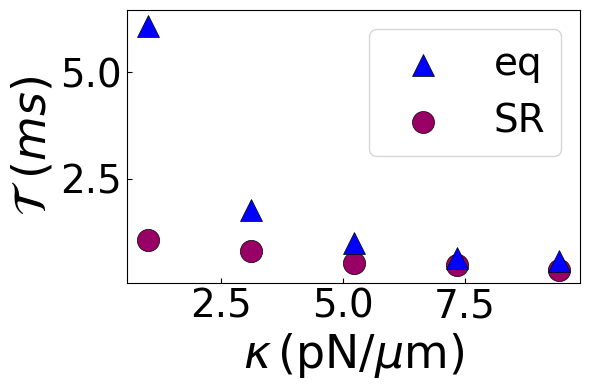

In [88]:
real_time = convert_arbitrary_time_to_seconds(gamma)
real_time_ms = real_time * 1e3  # convert to ms
resetting_real_time = r_varing_k / real_time_ms
print('resetting rate:', resetting_real_time)
fig, ax  = plt.subplots(figsize=(6, 4))
for i, k in enumerate(Ks_varing_k):
    if k>11:
        break
    tau_resetting = mean_relaxation_times_varing_k_raw[i]*real_time_ms # convert to ms
    tau_boltz = mean_relaxation_times_varing_k_boltz[i]*real_time_ms # convert to ms
    std_resetting = np.sqrt(1/10)*std_relaxation_times_varing_k_raw[i]*real_time_ms # convert to ms
    std_boltz = np.sqrt(1/10)*std_relaxation_times_varing_k_boltz[i]*real_time_ms # convert to ms
    ax.errorbar(Ks_varing_k[i], tau_resetting, yerr=std_resetting, linestyle='--', marker = 'o', lw=4, ms=16, color=color_resetting, markeredgecolor='black', markeredgewidth=0.5)
    ax.errorbar(Ks_varing_k[i], tau_boltz, yerr=std_boltz, linestyle='--', marker = '^', lw=4, ms=16, color='b', markeredgecolor='black', markeredgewidth=0.5)
ax.set_xlabel('$\\kappa \\, \\mathrm{(pN/}\\mu\\mathrm{m)}$', fontsize=33)
ax.set_ylabel('$\\mathcal{T}$ $(ms)$', fontsize=33)
ax.tick_params(axis='both', which='both', labelsize=28, direction='in')
legned_handels = []
boltz_handle = plt.scatter([],[], marker='^', color='blue', label='eq', s =250, edgecolor='black', linewidth=0.5)
resetting_handle = plt.scatter([],[], marker='o', color=color_resetting, label='SR', s=250, edgecolor='black', linewidth=0.5)
legned_handels.append(boltz_handle)
legned_handels.append(resetting_handle)
ax.legend(handles=legned_handels, loc='upper right', fontsize=28)
#plt.xscale('log')
#plt.yscale('log')
fig.tight_layout()
figname = 'b - Relaxation by stiffness - Harmonic - normalized.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
figname = 'b - Relaxation by stiffness - Harmonic - normalized.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

rate which halves relaxation time: 0.016 #
rate which halves relaxation time: 8.0 omega_0
rate which halves relaxation time: 0.9537374866930058 ms^-1


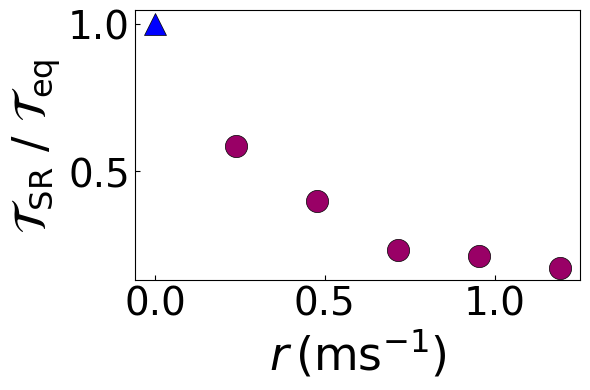

In [89]:
omega_0 = Ks[3]/gamma
print('rate which halves relaxation time:', resetting_rates_k_1[4], '#')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/omega_0, 'omega_0')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/real_time_ms, 'ms^-1')

fig, ax = plt.subplots(figsize=(6, 4))
for i, r in enumerate(resetting_rates_k_1):
    if i == 0:
        color = 'Blue'
        marker = '^'
    else:
        color = color_resetting
        marker = 'o'
    yerr = np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_1_raw[i]/mean_relaxation_times_varing_r_k_1_raw[0])**2 + ((mean_relaxation_times_varing_r_k_1_raw[i]*std_relaxation_times_varing_r_k_1_raw[0])/(mean_relaxation_times_varing_r_k_1_raw[0]**2))**2)
    ax.errorbar(resetting_rates_k_1[i]/real_time_ms, mean_relaxation_times_varing_r_k_1_raw[i]/mean_relaxation_times_varing_r_k_1_raw[0], yerr=yerr, linestyle='--', marker = marker, lw=4, ms=16, color=color, markeredgecolor='black', markeredgewidth=0.5)
ax.set_xlabel('$r \\, \\mathrm{(ms^{-1})}$', fontsize=33)
ax.set_ylabel('$\\mathcal{T}_{\\rm SR}$ / $\\mathcal{T}_{\\rm eq}$', fontsize=33)
ax.tick_params(axis='both', which='both', labelsize=28, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'c - Relaxation by resetting rate - Harmonic.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

omega_0: 0.002
omega_0 in ms^-1: 0.11921718583662573
rate which halves relaxation time: 0.016 #
rate which halves relaxation time: 8.0 omega_0
rate which halves relaxation time: 0.9537374866930058 ms^-1
slope: 4.168567118283668


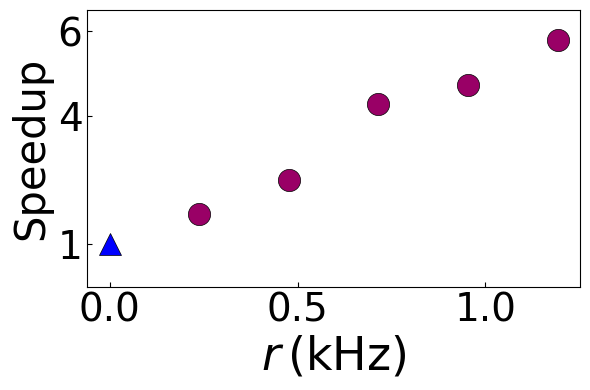

In [90]:
### As speed up:

def teq_tsr(r, omega_0):
    return r/(2*omega_0) + 1

omega_0 = Ks[3]/gamma
print('omega_0:', omega_0)
omega_0_ms = omega_0 / real_time_ms  # convert to ms^-1
print('omega_0 in ms^-1:', omega_0_ms)
print('rate which halves relaxation time:', resetting_rates_k_1[4], '#')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/omega_0, 'omega_0')
print('rate which halves relaxation time:', resetting_rates_k_1[4]/real_time_ms, 'ms^-1')

fig, ax = plt.subplots(figsize=(6, 4))
for i, r in enumerate(resetting_rates_k_1):
    if i == 0:
        color = 'Blue'
        marker = '^'
    else:
        color = color_resetting
        marker = 'o'
    yerr = np.sqrt(1/1)*np.sqrt((std_relaxation_times_varing_r_k_1_raw[0]/mean_relaxation_times_varing_r_k_1_raw[i])**2 + ((mean_relaxation_times_varing_r_k_1_raw[0]*std_relaxation_times_varing_r_k_1_raw[i])/(mean_relaxation_times_varing_r_k_5_raw[i]**2))**2)
    ax.errorbar(resetting_rates_k_1[i]/real_time_ms, mean_relaxation_times_varing_r_k_1_raw[0]/mean_relaxation_times_varing_r_k_1_raw[i], yerr=yerr, linestyle='--', marker = marker, lw=4, ms=16, color=color, markeredgecolor='black', markeredgewidth=0.5)
slope = np.polyfit(resetting_rates_k_1/real_time_ms, mean_relaxation_times_varing_r_k_1_raw[0]/mean_relaxation_times_varing_r_k_1_raw, 1)[0]
#ax.plot(resetting_rates_k_5/real_time_ms, teq_tsr(resetting_rates_k_5/real_time_ms, omega_0_ms), linestyle='-', lw=5, color='black', alpha=0.75)
print('slope:', slope)
ax.set_xlabel('$r \\, \\mathrm{(kHz)}$', fontsize=33)
#ax.set_ylabel('$\\mathcal{T}_{\\rm eq}$ / $\\mathcal{T}_{\\rm SR}$', fontsize=33)
ax.set_ylabel('Speedup', fontsize=30)
ax.set_yticks([1, 4,6], [1,4,6])
ax.set_ylim(0, 6.5)
ax.tick_params(axis='both', which='both', labelsize=28, direction='in')
fig.tight_layout()
figname = 'c - Relaxation by resetting rate - Harmonic - SPEEDUP.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'c - Relaxation by resetting rate - Harmonic - SPEEDUP.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

In [91]:
### concatenate the data for plotting ###
relxation_times = np.concatenate((mean_relaxation_times_varing_r_k_5, mean_relaxation_times_varing_r_k_1, mean_relaxation_times_varing_r_k_10))
std_relaxation_times = np.concatenate((std_relaxation_times_varing_r_k_5, std_relaxation_times_varing_r_k_1, std_relaxation_times_varing_r_k_10))
sherf_nums = np.concatenate((sherf_nums_k_5, sherf_nums_k_1, sherf_nums_k_10))

xy = zip(sherf_nums, relxation_times)
xy = sorted(xy, key=lambda x: x[0])  # Sort by the\
xy = np.array(xy)# Transpose to get x and y coordinates
print(xy[:,0])
### fit to 2/2+x ###
from scipy.optimize import curve_fit
def relative_characteristic_relaxation(x, a, b):
    return a / (b + x) 

popt, pcov = curve_fit(relative_characteristic_relaxation, xy[:,0], xy[:,1], p0=[2, 2])
fitted_relaxation_times = relative_characteristic_relaxation(xy[:,0], *popt)
a, b = popt
print(f'Fitted parameters: a={a:.3f}, b={b:.3f}')

[ 0.  0.  0.  2.  2.  2.  4.  4.  4.  6.  6.  6.  8.  8.  8. 10. 10. 10.]
Fitted parameters: a=2.215, b=2.211


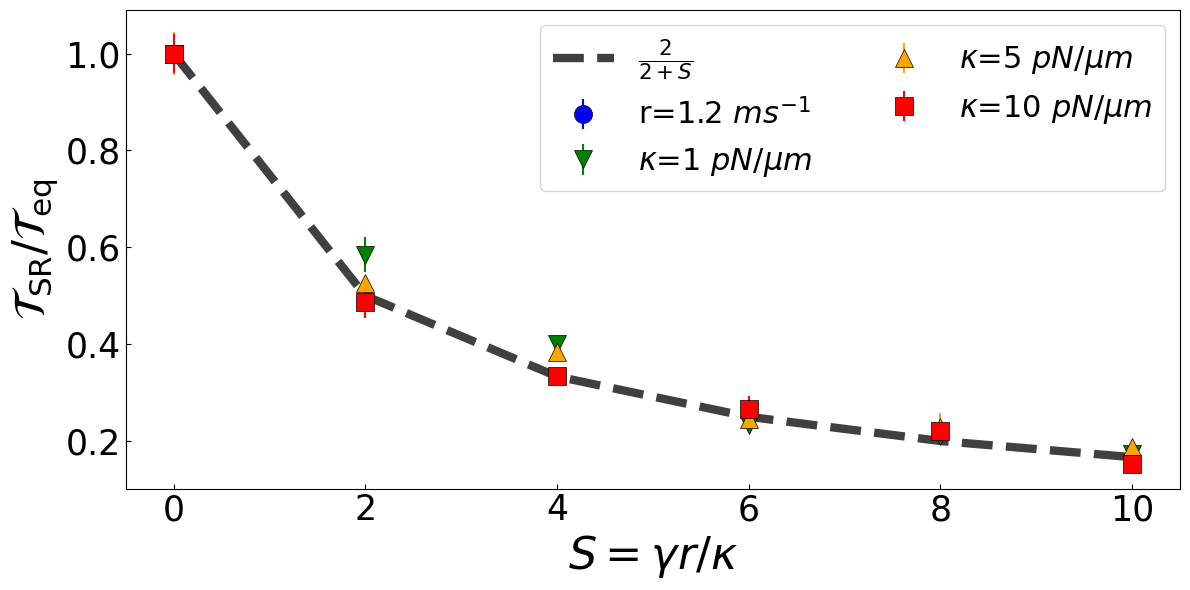

In [92]:
#### plot relaxation times as function of sherf numbers

plt.figure(figsize=(12, 6))
label_boltz = 'Thermal - $\\frac{\\gamma r}{K}$='+f'{0}'
label_varing_k = 'varying K'
plt.errorbar(sherf_nums_varing_k[:-10], mean_relaxation_times_varing_k[:-10], yerr=std_relaxation_times_varing_k[:-10], label=f'r={r_varing_k/real_time_ms:.1f} '+'$ ms^{-1}$', color='blue', marker='o', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.errorbar(sherf_nums_k_1, mean_relaxation_times_varing_r_k_1, yerr=std_relaxation_times_varing_r_k_1, label=f'$\\kappa$={Ks[3]} $pN/\\mu m$', color='green', marker='v', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.errorbar(sherf_nums_k_5, mean_relaxation_times_varing_r_k_5, yerr=std_relaxation_times_varing_r_k_5, label=f'$\\kappa$={Ks[0]} $pN/\\mu m$', color='orange', marker='^', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.errorbar(sherf_nums_k_10, mean_relaxation_times_varing_r_k_10, yerr=std_relaxation_times_varing_r_k_10, label=f'$\\kappa$={Ks[2]} $pN/\\mu m$', color='red', marker='s', markersize=13, linestyle='',markeredgecolor='black', markeredgewidth=0.5)
plt.plot(xy[:,0], relative_characteristic_relaxation(xy[:,0],2,2), linestyle='--', color='black', linewidth=6, label='$\\frac{2}{2+S}$', alpha=0.75)
plt.xlabel('$S=\\gamma r/ \\kappa$',fontsize=32)
plt.ylabel('$\\mathcal{T}_{\\rm SR}/\\mathcal{T}_{\\rm eq}$', fontsize=32)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.legend(fontsize= 22, ncols=2)
plt.tick_params(axis='both', which='both', labelsize=25, direction='in')
plt.tight_layout()
figname = 'SherfNumber all curves.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'SherfNumber all curves.svg'
path = os.path.join('Figures/Figure2',figname)
#plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

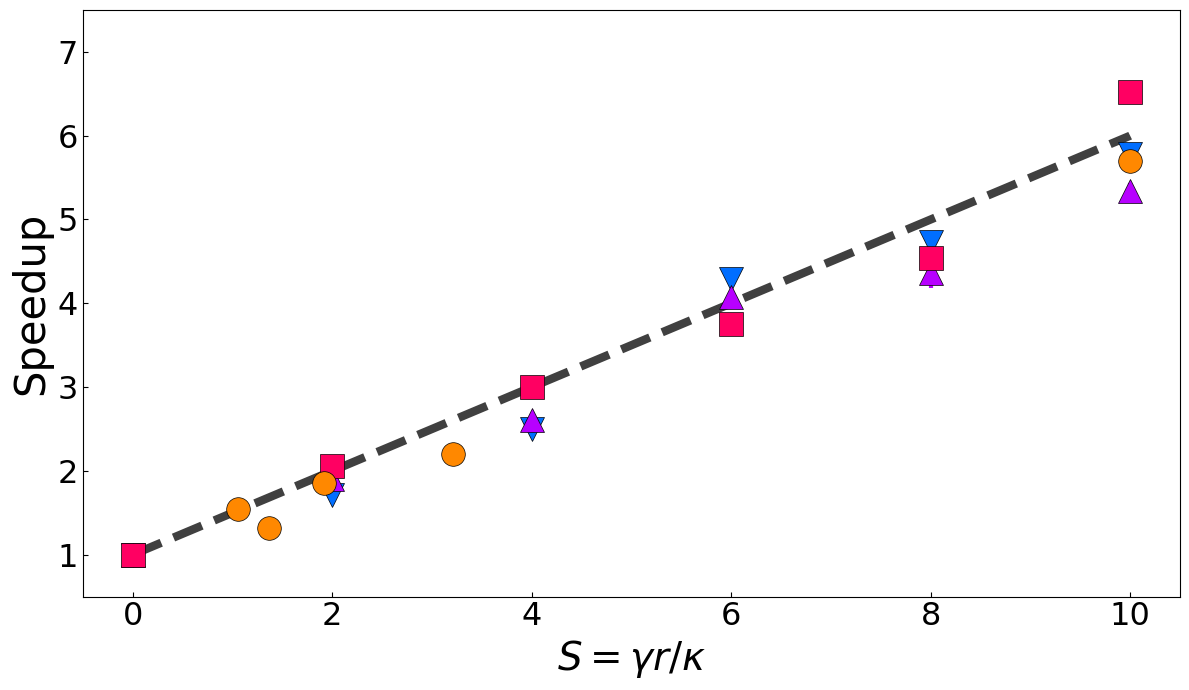

In [93]:
#### plot relaxation times as function of sherf numbers as SPEEDUP

plt.figure(figsize=(12, 7))
label_boltz = 'Thermal - $\\frac{\\gamma r}{K}$='+f'{0}'
label_varing_k = 'varying K'
varying_k_color = "#FF8800"
k_1_color = "#006EFF"
k_5_color = "#B700FF"
k_10_color = "#FF0062"
yerr_k_1 = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_1[0]/mean_relaxation_times_varing_r_k_1[i])**2 + ((mean_relaxation_times_varing_r_k_1[0]*std_relaxation_times_varing_r_k_1[i])/(mean_relaxation_times_varing_r_k_1[i]**2))**2) for i in range(len(mean_relaxation_times_varing_r_k_1_raw))]
yerr_k_5 = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_5[0]/mean_relaxation_times_varing_r_k_5[i])**2 + ((mean_relaxation_times_varing_r_k_5[0]*std_relaxation_times_varing_r_k_5[i])/(mean_relaxation_times_varing_r_k_5[i]**2))**2) for i in range(len(mean_relaxation_times_varing_r_k_5_raw))]
yerr_k_10 = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_r_k_10[0]/mean_relaxation_times_varing_r_k_10[i])**2 + ((mean_relaxation_times_varing_r_k_10[0]*std_relaxation_times_varing_r_k_10[i])/(mean_relaxation_times_varing_r_k_10[i]**2))**2) for i in range(len(mean_relaxation_times_varing_r_k_10_raw))]
yerr_varying_k = [np.sqrt(1/10)*np.sqrt((std_relaxation_times_varing_k_raw[0]/mean_relaxation_times_varing_k_raw[i])**2 + ((mean_relaxation_times_varing_k_raw[0]*std_relaxation_times_varing_k_raw[i])/(mean_relaxation_times_varing_k_raw[i]**2))**2) for i in range(len(mean_relaxation_times_varing_k))]
plt.errorbar(sherf_nums_k_1, 1/mean_relaxation_times_varing_r_k_1, yerr=yerr_k_1, label=f'$\\kappa={Ks[3]}\\,$'+ '$\\mathrm{pN/}\\mu\\mathrm{m}$', color=k_1_color, marker='v', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.errorbar(sherf_nums_k_5, 1/mean_relaxation_times_varing_r_k_5, yerr=yerr_k_5, label=f'$\\kappa$={Ks[0]} $pN/\\mu m$', color=k_5_color, marker='^', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.errorbar(sherf_nums_k_10, 1/mean_relaxation_times_varing_r_k_10, yerr=yerr_k_10, label=f'$\\kappa$={Ks[2]} $pN/\\mu m$', color=k_10_color, marker='s', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.errorbar(sherf_nums_varing_k[:-5], 1/mean_relaxation_times_varing_k[:-5], yerr=yerr_varying_k[:-5], label=f'r={r_varing_k/real_time_ms:.1f} '+'$ ms^{-1}$', color=varying_k_color, marker='o', markersize=17, linestyle='',markeredgecolor='black', markeredgewidth=0.5, linewidth=3)
plt.plot(xy[:,0], 1/relative_characteristic_relaxation(xy[:,0],2,2), linestyle='--', color='black', linewidth=6, label='$\\frac{2}{2+S}$', alpha=0.75)
plt.xlabel('$S=\\gamma r/ \\kappa$',fontsize=28)
plt.ylabel('Speedup', fontsize=30)
plt.xticks(fontsize=23)
plt.yticks(fontsize=23)
plt.ylim(0.5,7.5)
#plt.legend(fontsize= 22, ncols=2)
plt.tick_params(axis='both', which='both', labelsize=23, direction='in')
plt.tight_layout()
figname = 'SherfNumber all curves - SPEEDUP.png'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=300)
figname = 'SherfNumber all curves - SPEEDUP.svg'
path = os.path.join('Figures/Figure2',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=300)
plt.show()

## Spatial Exploration Tradeoff (FIG 3)

In [95]:
dt = 0.1
gamma = 500
kT = 1
delta_fractions = np.linspace(0, 0.01, 6)
resetting_rates_k_1 = (1/5)*delta_fractions/dt
resetting_rates_k_5 = delta_fractions/dt
resetting_rates_k_2 = (2/5)*delta_fractions/dt
resetting_rates_k_10 = (10/5)*delta_fractions/dt
typical_length_scale_k_1 = kT/1
typical_length_scale_k_5 = kT/5
typical_length_scale_k_2 = kT/2
typical_length_scale_k_10 = kT/10
resetting_rates_str_k_1 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_1]
resetting_rates_str_k_1 = ','.join(resetting_rates_str_k_1)
resetting_rates_str_k_5 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_5]
resetting_rates_str_k_5 = ','.join(resetting_rates_str_k_5)
resetting_rates_str_k_2 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_2]
resetting_rates_str_k_2 = ','.join(resetting_rates_str_k_2)
resetting_rates_str_k_10 = [f'{rate:.3f}'[1:] for rate in resetting_rates_k_10]
resetting_rates_str_k_10 = ','.join(resetting_rates_str_k_10)
varing_r_k_1_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_1}_K-{1}'
varing_r_k_5_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_5}'
varing_r_k_2_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_2}_K-{2}'
varing_r_k_10_folder = folder = f'HarmonicPotentialTrajectories/R-{resetting_rates_str_k_10}_K-{10}'
Ks = [5,2,10,1]
mean_relaxation_times_varing_r_k_5 = np.load(varing_r_k_5_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_1 = np.load(varing_r_k_1_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_2 = np.load(varing_r_k_2_folder+'/mean_platue_indices_per_r.npy')
mean_relaxation_times_varing_r_k_10 = np.load(varing_r_k_10_folder+'/mean_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_5 = np.load(varing_r_k_5_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_1 = np.load(varing_r_k_1_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_2 = np.load(varing_r_k_2_folder+'/std_platue_indices_per_r.npy')
std_relaxation_times_varing_r_k_10 = np.load(varing_r_k_10_folder+'/std_platue_indices_per_r.npy')

vars_k_5 = np.load(varing_r_k_5_folder+'/var_trajectories.npy')
vars_k_2 = np.load(varing_r_k_2_folder+'/var_trajectories.npy')
vars_k_10 = np.load(varing_r_k_10_folder+'/var_trajectories.npy')
vars_k_1 = np.load(varing_r_k_1_folder+'/var_trajectories.npy')
means_k_5 = np.load(varing_r_k_5_folder+'/mean_trajectories.npy')
means_k_2 = np.load(varing_r_k_2_folder+'/mean_trajectories.npy')
means_k_10 = np.load(varing_r_k_10_folder+'/mean_trajectories.npy')
means_k_1 = np.load(varing_r_k_1_folder+'/mean_trajectories.npy')


mean_relaxation_times_varing_r_k_1 = mean_relaxation_times_varing_r_k_1/mean_relaxation_times_varing_r_k_1[0]
std_relaxation_times_varing_r_k_1 = std_relaxation_times_varing_r_k_1/mean_relaxation_times_varing_r_k_1[0]
mean_relaxation_times_varing_r_k_5 = mean_relaxation_times_varing_r_k_5/mean_relaxation_times_varing_r_k_5[0]
std_relaxation_times_varing_r_k_5 = std_relaxation_times_varing_r_k_5/mean_relaxation_times_varing_r_k_5[0]
mean_relaxation_times_varing_r_k_2 = mean_relaxation_times_varing_r_k_2/mean_relaxation_times_varing_r_k_2[0]
std_relaxation_times_varing_r_k_2 = std_relaxation_times_varing_r_k_2/mean_relaxation_times_varing_r_k_2[0]
mean_relaxation_times_varing_r_k_10 = mean_relaxation_times_varing_r_k_10/mean_relaxation_times_varing_r_k_10[0]
std_relaxation_times_varing_r_k_10 = std_relaxation_times_varing_r_k_10/mean_relaxation_times_varing_r_k_10[0]

sherf_nums_k_1 = gamma * resetting_rates_k_1 / Ks[3]
sherf_nums_k_5 = gamma * resetting_rates_k_5 / Ks[0]
sherf_nums_k_2 = gamma * resetting_rates_k_2 / Ks[1]
sherf_nums_k_10 = gamma * resetting_rates_k_10 / Ks[2]
print('sherf_nums_k_1',sherf_nums_k_1)
print('sherf_nums_k_5',sherf_nums_k_5)
print('sherf_nums_k_2',sherf_nums_k_2)
print('sherf_nums_k_10',sherf_nums_k_10)   

sherf_nums_k_1 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_5 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_2 [ 0.  2.  4.  6.  8. 10.]
sherf_nums_k_10 [ 0.  2.  4.  6.  8. 10.]


In [96]:
### check average means ### 
mean_per_S_k_1 = np.mean(means_k_1, axis=1)
mean_per_S_k_5 = np.mean(means_k_5, axis=1)
mean_per_S_k_2 = np.mean(means_k_2, axis=1)
mean_per_S_k_10 = np.mean(means_k_10, axis=1)
print('mean_per_S_k_1', mean_per_S_k_1)
print('mean_per_S_k_5', mean_per_S_k_5)
print('mean_per_S_k_2', mean_per_S_k_2)
print('mean_per_S_k_10', mean_per_S_k_10)

mean_per_S_k_1 [-0.00030136 -0.00081824  0.00166694  0.00028607 -0.00022215  0.00083225]
mean_per_S_k_5 [-3.8522066e-04  1.5671476e-05  1.9622399e-04  4.2967091e-04
 -1.1096277e-04  2.8614749e-04]
mean_per_S_k_2 [-2.3479857e-03 -2.9680697e-05  5.3253368e-04 -5.6134246e-04
 -2.8437382e-04  4.9955089e-04]
mean_per_S_k_10 [-2.6569469e-04 -5.6554738e-05 -2.2454701e-04 -1.5586529e-04
  1.7945369e-05 -9.9917001e-05]


In [97]:
def calculate_SS_var_by_rate(vars):
    SS_var_by_rate_resetting = []
    target_distribution_samples = 500
    for vars_per_rate in vars:
        SS_var_resetting = np.mean(vars_per_rate[-target_distribution_samples:])
        std_SS_var_resetting = np.std(vars_per_rate[-target_distribution_samples:])
        SS_var_by_rate_resetting.append([SS_var_resetting, std_SS_var_resetting])
    SS_var_by_rate_resetting = np.array(SS_var_by_rate_resetting)
    return SS_var_by_rate_resetting

SS_var_by_rate_k_5 = calculate_SS_var_by_rate(vars_k_5)
SS_var_by_rate_k_2 = calculate_SS_var_by_rate(vars_k_2)
SS_var_by_rate_k_10 = calculate_SS_var_by_rate(vars_k_10)
SS_var_by_rate_k_1 = calculate_SS_var_by_rate(vars_k_1)

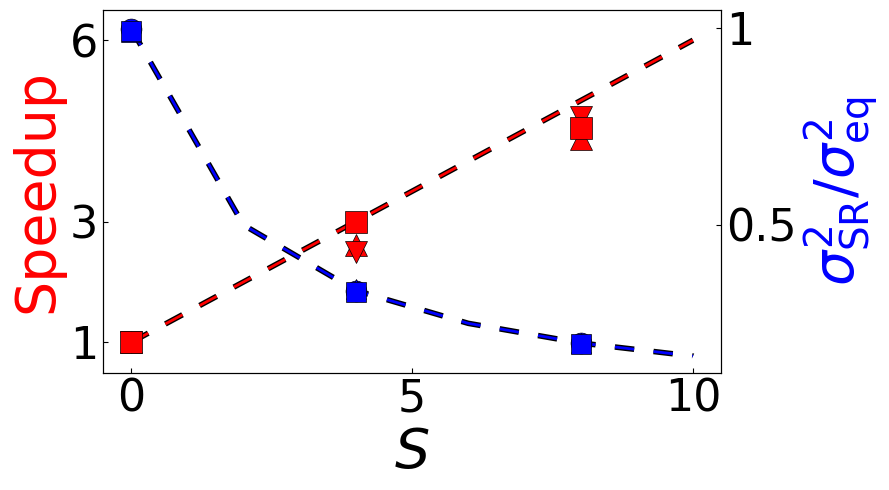

In [99]:

fig, ax1 = plt.subplots(figsize=(9, 5))
ax2 = ax1.twinx()


all_sherf_nums = np.concatenate((sherf_nums_k_5, sherf_nums_k_1, sherf_nums_k_10))
all_sherf_nums = np.sort(all_sherf_nums)
analytical_speedup_factor = np.pow(relative_characteristic_relaxation(all_sherf_nums, 2, 2),-1)
spatial_exploration_factor = relative_characteristic_relaxation(all_sherf_nums, 2, 2)

skip_indices = np.arange(1, len(sherf_nums_k_5), 2)

for i in range(len(sherf_nums_k_5)):
    if i in skip_indices:
        continue
    adjusted_platue = mean_relaxation_times_varing_r_k_5[0]/mean_relaxation_times_varing_r_k_5[i]
    yerr = std_relaxation_times_varing_r_k_5[i]/mean_relaxation_times_varing_r_k_5[0]
    ax1.errorbar(sherf_nums_k_5[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_5[i,1], linestyle="", marker = '^', lw=3, ms=16, color='red', markeredgecolor='black', markeredgewidth=0.5)
    ax2.errorbar(sherf_nums_k_5[i], SS_var_by_rate_k_5[i, 0]/typical_length_scale_k_5, yerr=SS_var_by_rate_k_5[i, 1]/typical_length_scale_k_5, linestyle="", marker = 'o', lw=3, ms=15, color='blue', markeredgecolor='black', markeredgewidth=0.5)

for i in range(len(sherf_nums_k_1)):
    if i in skip_indices:
        continue
    adjusted_platue = mean_relaxation_times_varing_r_k_1[0]/mean_relaxation_times_varing_r_k_1[i]
    yerr = std_relaxation_times_varing_r_k_1[i]/mean_relaxation_times_varing_r_k_1[0]
    ax1.errorbar(sherf_nums_k_1[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_1[i,1], linestyle="", marker = 'v', lw=3, ms=16, color='red', markeredgecolor='black', markeredgewidth=0.5)
    ax2.errorbar(sherf_nums_k_1[i], SS_var_by_rate_k_1[i, 0]/typical_length_scale_k_1, yerr=SS_var_by_rate_k_1[i, 1]/typical_length_scale_k_1, linestyle="", marker = '^', lw=3, ms=15, color='blue', markeredgecolor='black', markeredgewidth=0.5)

for i in range(len(sherf_nums_k_10)):
    if i in skip_indices:
        continue
    adjusted_platue = mean_relaxation_times_varing_r_k_10[0]/mean_relaxation_times_varing_r_k_10[i]
    yerr = std_relaxation_times_varing_r_k_10[i]/mean_relaxation_times_varing_r_k_10[0]
    ax1.errorbar(sherf_nums_k_10[i], adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_10[i,1], linestyle="", marker = 's', lw=3, ms=16, color='red', markeredgecolor='black', markeredgewidth=0.5)
    ax2.errorbar(sherf_nums_k_10[i], SS_var_by_rate_k_10[i, 0]/typical_length_scale_k_10, yerr=SS_var_by_rate_k_10[i, 1]/typical_length_scale_k_10, linestyle="", marker = 's', lw=3, ms=15, color='blue', markeredgecolor='black', markeredgewidth=0.5)

ax1.plot(all_sherf_nums, analytical_speedup_factor, linestyle='--', color='red',dashes=[7,7], linewidth=2, label='$\\frac{2}{2+S}$', path_effects=[pe.withStroke(linewidth=4, foreground='black')])
ax2.plot(all_sherf_nums, spatial_exploration_factor, linestyle='--', color='blue', dashes=[7,7], linewidth=2, label='$\\frac{2+S}{2}$', path_effects=[pe.withStroke(linewidth=4,foreground='black')])

ax1.set_xlabel('$S$', fontsize=40)
ax1.set_ylabel('Speedup', fontsize=40, color='red')
ax2.set_ylabel('$\\sigma_{\\rm SR}^2/\\sigma_{\\rm eq}^2$', fontsize=40, color='blue')
ax1.tick_params(axis='both', which='both', labelsize=32, direction='in')
ax2.tick_params(axis='both', which='both', labelsize=32, direction='in')
ax2.set_yticks([0.5, 1],[0.5,1])
ax1.set_yticks([1, 3, 6],[1, 3,6])
ax1.set_ylim(0.5, 6.5)
legned_handels = []
k_5_handle = plt.scatter([],[], marker='o', color='black', label='K=5', s=150)
k_2_handle = plt.scatter([],[], marker='^', color='black', label='K=1', s=150)
k_10_handle = plt.scatter([],[], marker='s', color='black', label='K=10', s=150)
relaxation_factor_handle = plt.Line2D([0], [0], color='red', linestyle='--', linewidth=3, label='$\\frac{2+S}{2}$')
spatial_exploration_factor_handle = plt.Line2D([0], [0], color='blue', linestyle='--', linewidth=3, label='$\\frac{2}{2+S}$')
legned_handels = [relaxation_factor_handle, spatial_exploration_factor_handle]
#ax2.legend(handles=legned_handels, loc='best', fontsize=23, ncols=2)
fig.tight_layout()
figname = 'Dual axis - Relaxation time by ss var - Harmonic - Vary rate.png'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
figname = 'Dual axis - Relaxation time by ss var - Harmonic - Vary rate.svg'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()

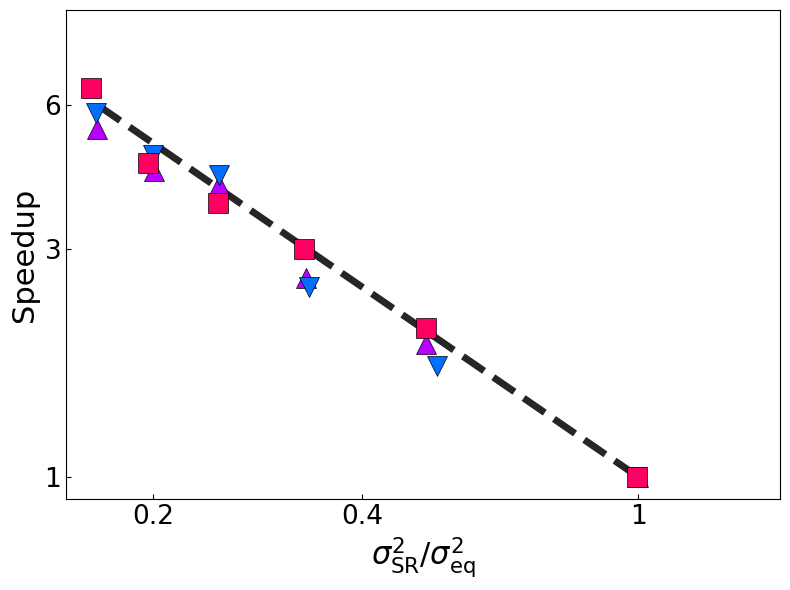

In [100]:
### Relaxation time by ss var ###

fig, ax = plt.subplots(figsize=(8, 6))

slope = -1
x_min = 0.3
x_max = 0.8
k_1_color = "#006EFF"
k_5_color = "#B700FF"
k_10_color = "#FF0062"
for i in range(len(sherf_nums_k_5)):
    adjusted_platue = mean_relaxation_times_varing_r_k_5[0]/mean_relaxation_times_varing_r_k_5[i]
    yerr = std_relaxation_times_varing_r_k_5[i]/mean_relaxation_times_varing_r_k_5[0]
    adjusted_platue_k_1 = mean_relaxation_times_varing_r_k_1[0]/mean_relaxation_times_varing_r_k_1[i]
    yerr_k_1 = std_relaxation_times_varing_r_k_1[i]/mean_relaxation_times_varing_r_k_1[0]
    adjusted_platue_k_10 = mean_relaxation_times_varing_r_k_10[0]/mean_relaxation_times_varing_r_k_10[i]
    yerr_k_10 = std_relaxation_times_varing_r_k_10[i]/mean_relaxation_times_varing_r_k_10[0]
    ax.errorbar(SS_var_by_rate_k_5[i,0]/typical_length_scale_k_5, adjusted_platue, yerr=yerr, xerr=SS_var_by_rate_k_5[i,1], linestyle="", marker = '^', lw=3, ms=15, color=k_5_color, markeredgecolor='black', markeredgewidth=0.5)
    ax.errorbar(SS_var_by_rate_k_1[i,0]/typical_length_scale_k_1, adjusted_platue_k_1, yerr=yerr_k_1, xerr=SS_var_by_rate_k_2[i,1], linestyle="", marker = 'v', lw=3, ms=15, color=k_1_color, markeredgecolor='black', markeredgewidth=0.5)
    ax.errorbar(SS_var_by_rate_k_10[i,0]/typical_length_scale_k_10, adjusted_platue_k_10, yerr=yerr_k_10, xerr=SS_var_by_rate_k_10[i,1], linestyle="", marker = 's', lw=3, ms=15, color=k_10_color, markeredgecolor='black', markeredgewidth=0.5)
ax.plot(SS_var_by_rate_k_1[:,0]/typical_length_scale_k_1, (SS_var_by_rate_k_1[:,0]/typical_length_scale_k_1)**-1, color='black', linestyle='--', linewidth=5, alpha=0.85)
ax.set_ylabel('Speedup', fontsize=22)
ax.set_xlabel('$\\sigma_{\\rm SR}^2/\\sigma_{\\rm eq}^2$', fontsize=22)
ax.set_xlim(0.15,1.6)
ax.set_ylim(0.9, 9.5)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', direction='in',)
ax.set_xticks(ticks=[0.2, 0.4, 1],labels=[0.2, 0.4, 1], minor=False, fontsize=19)
ax.set_yticks(ticks=[1,3,6],labels=['1', '3', '6'], minor=False, fontsize=19)
ax.minorticks_off()
#ax.plot([x_min,x_max], np.array([(x_min/1.2)**slope, (x_max/1.2)**slope]), color='black', linestyle='-', linewidth=4)
#ax.text(0.6, (0.6/1.7)**slope, f'$m={slope}$', fontsize=22, color='black', ha='center', va='center', fontdict={'weight': 'bold'})
k_5_handle = plt.scatter([],[], marker='o', color='red', label='$\\kappa$=5', s=200, edgecolors='black', linewidth=0.5)
k_2_handle = plt.scatter([],[], marker='^', color='green', label='$\\kappa$=2', s=200, edgecolors='black', linewidth=0.5)
k_10_handle = plt.scatter([],[], marker='s', color='blue', label='$\\kappa$=10', s=200, edgecolors='black', linewidth=0.5)
theo_handle = plt.Line2D([], [], color='black', linestyle='--', linewidth=5, label='$y=x^{-1}$', alpha=0.85)
legend_handles = [k_5_handle, k_2_handle, k_10_handle]
#ax.legend(handles=[theo_handle], fontsize=26, loc='best')
fig.tight_layout()
figname = 'Relaxation time by ss var - Harmonic - Vary rate.png'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='png', dpi=500)
figname = 'Relaxation time by ss var - Harmonic - Vary rate.svg'
path = os.path.join('Figures/Figure4',figname)
plt.savefig(path, bbox_inches='tight',format='svg', dpi=500)
plt.show()